<h1>CS4618: Artificial Intelligence I</h1>
<h1>Neural Network Examples</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [41]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.optimizers import SGD

from sklearn.datasets import load_iris
from tensorflow.keras.datasets.mnist import load_data

In [43]:
# Cork Property Prices Dataset

# Use pandas to read the CSV file into a DataFrame
cork_df = pd.read_csv("../datasets/dataset_corkA.csv")

# Shuffle the dataset
cork_df = cork_df.sample(frac=1, random_state=2)
cork_df.reset_index(drop=True, inplace=True)

# Split off the test set: 20% of the dataset.
dev_cork_df, test_cork_df = train_test_split(cork_df, train_size=0.8, random_state=2)

# The features 
cork_features = ["flarea", "bdrms", "bthrms"]

# Create the preprocessor
cork_preprocessor = ColumnTransformer([
        ("scaler", StandardScaler(), cork_features)],
        remainder="passthrough")

# Extract the features but leave as a DataFrame
dev_cork_X = dev_cork_df[cork_features]
test_cork_X = test_cork_df[cork_features]

# Target values, converted to a 1D numpy array
dev_cork_y = dev_cork_df["price"].values
test_cork_y = test_cork_df["price"].values

In [44]:
# CS1109 Dataset

# Use pandas to read the CSV file into a DataFrame
cs1109_df = pd.read_csv("../datasets/dataset_cs1109.csv")

# Shuffle the dataset
cs1109_df = cs1109_df.sample(frac=1, random_state=2)
cs1109_df.reset_index(drop=True, inplace=True)

# Split off the test set: 20% of the dataset. Note the stratification
dev_cs1109_df, test_cs1109_df = train_test_split(cs1109_df, train_size=0.8, 
                                                     stratify=cs1109_df["outcome"], random_state=2)

# The features 
cs1109_features = ["lect", "lab", "cao"]

# Create the preprocessor
cs1109_preprocessor = ColumnTransformer([
        ("scaler", StandardScaler(), cs1109_features)],
        remainder="passthrough")

# Extract the features but leave as a DataFrame
dev_cs1109_X = dev_cs1109_df[cs1109_features]
test_cs1109_X = test_cs1109_df[cs1109_features]

# Target values, encoded and converted to a 1D numpy array
label_encoder = LabelEncoder()
label_encoder.fit(cs1109_df["outcome"])
dev_cs1109_y = label_encoder.transform(dev_cs1109_df["outcome"])
test_cs1109_y = label_encoder.transform(test_cs1109_df["outcome"])

In [45]:
# Iris dataset

# Load the dataset (a dictionary) and get the features DataFrame and target values from the dictionary
iris = load_iris(as_frame=True)
iris_df = iris.data
iris_y = iris.target

# Shuffle the features and the target values in the same way
idx = np.random.permutation(iris_df.index)
iris_df.reindex(idx)
iris_y.reindex(idx)
iris_df.reset_index(drop=True, inplace=True)
iris_y.reset_index(drop=True, inplace=True)

# Split off the test set: 20% of the dataset.
dev_iris_df, test_iris_df, dev_iris_y, test_iris_y = train_test_split(iris_df, iris_y, train_size=0.8, 
                                                                              random_state=4)

# Create the preprocessor
iris_preprocessor = ColumnTransformer([
        ("scaler", StandardScaler(), iris_df.columns)],
        remainder="passthrough")

<h1>Introduction</h1>
<ul>
    <li>We'll use layered, dense, feedforward neural networks for regression, binary classification
        and multi-class classification:
        <ul>
            <li>We'll use our three small datasets that contain 'structured' data (sometimes
                called 'tabular' data): not necessarily ideal for deep learning.</li>
            <li>We'll see one example that uses images.</li>
        </ul>
    </li>
    <li>This will illustrate some of the different activation functions we can use:
        <ul>
            <li>in the output layer: linear, sigmoid or softmax; and</li>
            <li>in the hidden layers: sigmoid or ReLU.</li>
        </ul>
    </li>
    <li>This will also introduce the Keras library.</li>
</ul>

<h1>The Keras library</h1>
<ul>
    <li>scikit-learn has very limited support for neural networks.</li>
    <li>There are now many libraries that do support tensor computation, neural neworks and deep learning 
         including in Python:
        <ul>
            <li>Tensorflow, PyTorch, Caffe, Theano, CNTK.</li>
        </ul>
    </li>
    <li>We will use Keras, which is a high-level API for Tensorflow, first released in 2015
        by Fran&ccedil;ois Chollet of Google (<a href="https://keras.io">https://keras.io</a>), which has done
        a lot to make Deep Learning accessible to people:
        <ul>
            <li>It is very high-level, making it easy to construct networks, fit models and make predictions.</li>
            <li>The downside is it gives less fine-graned control than TensorFlow itself.</li>
            <li>This seems a suitable trade-off for us: our module is about AI, not the intricacies of
                TensorFlow.
            </li>
        </ul>
    </li>
    <li>For simple neural networks, Keras is even compatible with scikit-learn:
        <ul>
            <li>Using wrappers, we can have simple neural networks at the end of our pipelines.</li>
        </ul>
    </li>
</ul>

<h1>Keras concepts</h1>
<ul>
    <li><b>Layers</b> are the building blocks.
        <ul>
            <li>To begin with, we will use <b>dense layers</b>.</li>
            <li>The activation functions of <em>hidden layers</em> are open for you to choose, 
                e.g. sigmoid or ReLU.
            </li>
            <li>But the activation functions of <em>output layers</em> are determined by the task:
                <ul>
                    <li>Regression: linear activation function (default);</li>
                    <li>Binary classification: sigmoid activation function; and</li>
                    <li>Multiclass classification: softmax activation function.</li>
                </ul>
            </li>
        </ul>
    </li>
    <li>Layers are combined into <b>networks</b>:
        <ul>
            <li>Consecutive layers must be compatible: the shape of the input to one layer is the shape of 
                the output of the preceding layer.
            </li>
            <li>In early lectures, we only consider a stack of layers but Keras allows directed acyclic graphs 
                and, later, we will briefly discuss some examples that are not just stacks of layers.
            </li>
        </ul>
    </li>
    <li>Once the network is built, we <b>compile</b> it, specifying:
        <ul>
            <li>A <b>loss function</b>:
                <ul>
                    <li>Regression, e.g. mean-squared-error (<code>mse</code>);</li>
                    <li>Binary classification, e.g. (binary) cross-entropy (<code>binary_crossentropy</code>);</li>
                    <li>Multiclass classification, e.g. (categorical) cross-entropy 
                        (<code>sparse_categorical_crossentropy</code> if the labels are encoded as
                        integer labels
                        or <code>categorical_crossentropy</code> if the integer labels are then also one-hot
                        encoded).</li>
                </ul>
            </li>
            <li>An <b>optimizer</b>, such as SGD &mdash; but see below.</li>
            <li>A list of metrics to monitor during training and testing:
                <ul>
                    <li>Regression, e.g. mean-absolute-error (<code>mae</code>);</li>
                    <li>Classification, e.g. accuracy (<code>acc</code>).</li>
                </ul>
            </li>
        </ul>
    </li>
</ul>

<h1>Keras optimizers</h1>
<ul>
    <li>We know about Gradient Descent: Batch, Mini-Batch, Stochastic.</li>
    <li>Without going into details, many other variants of Gradient Descent have been devised:
        <ul>
            <li>some may have better convergence behaviour in the case of local minima;</li>
            <li>some may converge more quickly.</li>
        </ul>
        although a disadvantage is that they typically introduce further hyperparameters
        (e.g. momentum) in addition to learning rate.
    </li>
    <li>We'll use SGD below.
        <ul>
            <li>Be aware, the Keras default SGD learning rate is 0.01 &mdash; quite high, 
                often resulting in divergence, so we must often change it.
            </li>
            <li>Be aware too that, although this optimizer is called SGD, behaviour depends on the
                <code>batch_size</code>. If <code>batch_size</code> is 1, then this is what we earlier
                called Stochastic Gradient Descent; if <code>batch_size</code> is equal to the size 
                of the training set
                (excluding the validation set), then we get the equivalent of what we called Batch Gradient
                Descent; and if it is somewhere in between (which, in fact, is the most common way
                of training models in Keras), then it is Mini-Batch Gradient Descent.
            </li>
        </ul>
    </li>
</ul>

In [46]:
# tensorflow give warnings that explain that tensorflow was originally compiled on a different computer 
# architecture from the one you are using. This means its performance may not be optimal.
# It explains that, if you want to optimize tensorflow for your architecture, then you need to rebuild (recompile)
# tensorflow from scratch. We won't do this!

<h1>A Neural Network for Regression</h1>
<ul>
    <li>For regression on structured/tabular data, we might use a network with the following architecture:
        <ul>
            <li>Input layer: one input per feature.</li>
            <li>Hidden layers: one or more hidden layers.
                <ul>
                    <li>Activation function for neurons in hidden layers can be the sigmoid function or ReLU.
                </ul>
            </li>
            <li>Output layer: just one output neuron (assuming we're predicting a single number).
                <ul>
                    <li>Activation function for the output neuron should be the <b>linear function</b>: 
                        $g(z) = z$
                    </li>
                </ul>
            </li>
        </ul>
    </li>
    <li>(There are also biases in each layer except the output layer &mdash; Keras will give us these 
        'for free'.)
    </li>
</ul>

<h2>Example: Cork Property Prices</h2>
<ul>
    <li>We don't want too many hidden layers, nor too many neurons in each hidden layer. Why?</li>
    <li>Let's start with this:
        <ul>
            <li>An input layer with three inputs ($\mathit{flarea}$, $\mathit{bdrms}$, 
                $\mathit{bthrms}$);
            </li>
            <li>Two hidden layers, with 64 neurons in each, and ReLU activation function;</li>
            <li>An output layer with a single neuron and linear activation function.</li>
        </ul>
    </li>
</ul>

In [47]:
inputs = Input(shape=(3,))
x = Dense(64, activation="relu")(inputs)
x = Dense(64, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)
cork_model = Model(inputs, outputs)

cork_model.compile(optimizer=SGD(learning_rate=0.0001), loss="mse")

<ul>
    <li>Keras has improved its classes for preprocessing of data recently, and even does them as layers
        in the network. E.g. there are layers for scaling and one-hot encoding.
    </li>
    <li>However, when you have structured/tabular data, it remains easiest to preprocess it with scikit-learn.
        There is then a wrapper class that allows us to add a function that returns our neural network to the 
        end of a scikit-learn
        pipeline and run our usual scikit-learn methods.
    </li>
</ul>

In [48]:
# Create a pipeline
cork_pipeline = Pipeline([
    ("preprocessor", cork_preprocessor),
    ("predictor", KerasRegressor(build_fn=lambda: cork_model, verbose=0, epochs=60, batch_size=32))
])

In [49]:
# Error estimation
# We'll just train on the dev set and test on the test set
# If you want to use ShuffleSplit, KFold, cross_val_score and so on, then you can - in the usual way.
# But you may get a warning about an inefficiency in your code. We won't worry aboout this warning. 

cork_pipeline.fit(dev_cork_X, dev_cork_y)

mean_absolute_error(test_cork_y, cork_pipeline.predict(test_cork_X))

84.792482601699

<ul>
    <li>Feel free to edit the code, e.g. add or remove hidden layers, change the number of neurons in the
        hidden layers, change ReLU to sigmoid, change from SGD to another optimizer, change the learning rate,
        change the number of epochs,
        or change the batch size.
    </li>
</ul>

<h1>A Neural Network for Binary Classification</h1>
<ul>
    <li>For binary classification, we might use a network with the following architecture:
        <ul>
            <li>Input layer: one input per feature.</li>
            <li>Hidden layers: one or more hidden layers.
                <ul>
                    <li>Activation function for neurons in hidden layers can be sigmoid or ReLU.</li>
                </ul>
            </li>
            <li>Output layer: just one output neuron (for binary classification).
                <ul>
                    <li>Activation function for the output neuron should be the sigmoid function also. Why?</li>
                </ul>
            </li>
        </ul>
    </li>
</ul>

<h2>Example: CS1109 Dataset</h2>
<ul>
    <li>Let's start with this:
        <ul>
            <li>An input layer with 3 inputs ($\mathit{lect}$, $\mathit{lab}$, $\mathit{cao}$).</li>
            <li>Two hidden layers, with 64 neurons in each, and ReLU activation function.</li>
            <li>An output layer with a single neuron and sigmoid activation function.</li>
        </ul>
    </li>
</ul>

In [50]:
inputs = Input(shape=(3,))
x = Dense(64, activation="relu")(inputs)
x = Dense(64, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
cs1109_model = Sequential(Model(inputs, outputs)) # For classification, scikit-learn requires me to add Sequential(...)

cs1109_model.compile(optimizer=SGD(learning_rate=0.001), loss="binary_crossentropy")

In [51]:
# Create a pipeline
cs1109_pipeline = Pipeline([
    ("preprocessor", cs1109_preprocessor),
    ("estimator", KerasClassifier(build_fn=lambda: cs1109_model, verbose=0, epochs=60, batch_size=32))
])

In [52]:
# Accuracy estimation

cs1109_pipeline.fit(dev_cs1109_X, dev_cs1109_y)

# You may get a warning because scikit-learn is using tensorflow in a deprecated way
accuracy_score(test_cs1109_y, cs1109_pipeline.predict(test_cs1109_X))

/Users/dgb/miniforge3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.7101449275362319

<h1>A Neural Network for Multi-Class Classification</h1>
<ul>
    <li>For multi-class classification, we might use a network with the following architecture:
        <ul>
            <li>Input layer: one input per feature.</li>
            <li>Hidden layers: one or more hidden layers.
                <ul>
                    <li>Activation function for neurons in hidden layers can be sigmoid or ReLU.</li>
                </ul>
            </li>
            <li>Output layer: one output neuron per class.
                <ul>
                    <li>Activation function for the output neurons should be the softmax function.</li>
                </ul>
            </li>
        </ul>
    </li>
</ul>

<h2>Example: Iris Dataset</h2>
<ul>
    <li>Let's start with this:
        <ul>
            <li>An input layer with 4 inputs (petal width and length, and sepal width and length).</li>
            <li>Two hidden layers, with 64 neurons in each, and ReLU activation function.</li>
            <li>An output layer with three neurons (one for Setosa, Versicolor and Virginica) and 
                softmax activation function.
            </li>
        </ul>
    </li>
</ul>

In [53]:
inputs = Input(shape=(4,))
x = Dense(64, activation="relu")(inputs)
x = Dense(64, activation="relu")(x)
outputs = Dense(3, activation="softmax")(x)
iris_model = Sequential(Model(inputs, outputs))

iris_model.compile(optimizer=SGD(learning_rate=0.01), loss="sparse_categorical_crossentropy")

<ul>
    <li>Note the loss function above:
        <ul>
            <li><code>sparse_categorical_crossentropy</code> for multi-class classificastion when the classes
                are integers, e.g. 0 = one kind of Iris, 1 = another kind, 2 = a third kind (which is what
                we have in the Iris dataset).
            </li>
            <li><code>categorical_cross_entropy</code> for multi-class classification when the classes have
                been one-hot encoded.
            </li>
            <li>(And, as we've seen, <code>binary_crossentropy</code> for binary classification, where the classes
                will be 0 or 1.)
            </li>
        </ul>
    </li>
</ul>

In [54]:
# Create a pipeline
iris_pipeline = Pipeline([
    ("preprocessor", iris_preprocessor),
    ("predictor", KerasClassifier(build_fn=lambda: iris_model, verbose=0, epochs=60, batch_size=32))
])

In [55]:
# Accuracy estimation

iris_pipeline.fit(dev_iris_df, dev_iris_y)

# May get same warning
accuracy_score(test_iris_y, iris_pipeline.predict(test_iris_df))

/Users/dgb/miniforge3/envs/tf25/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.9666666666666667

<h1>A Final Example: MNIST</h1>
<ul>
    <li>MNIST is a classic dataset for multi-class classification.</li>
    <li>The task is classification of hand-written digits.
        <ul>
            <li>Features: 28 pixel by 28 pixel grayscale images of hand-written digits.
                <ul>
                    <li>The values are integers in $[0, 255]$.</li>
                </ul>
            </li>
            <li>Classes: 0 to 9.</li>
        </ul>
    </li>
    <li>Dataset: 70,000 images, so we can safely use holdout, and it is already partitioned:
        <ul>
            <li>60,000 training images;</li>
            <li>10,000 test images.</li>
        </ul>
    </li>
</ul>

In [56]:
# Keras has a utility function for downloading it into four Numpy arrays
# To get this to work on macOS, I also had to run this in a terminal:
# $ /Applications/Python\ 3.8/Install\ Certificates.command
# You may need something similar
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = load_data()

In [57]:
mnist_x_train.shape

(60000, 28, 28)

In [58]:
mnist_x_train.dtype

dtype('uint8')

In [59]:
np.unique(mnist_y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [60]:
mnist_x_test.shape

(10000, 28, 28)

In [61]:
np.unique(mnist_y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [62]:
idx = 126 # Change this number to look at other images
some_example = mnist_x_train[idx]

In [63]:
# Look at the raw data for this image. Warning: large! (28 by 28)
some_example

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  23,  79, 192, 216, 216,  91,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  13, 209, 252, 253, 252, 252, 227,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  38,
        147, 209, 252, 252, 244, 168,  80,  31,   0,   0,   0,   0,   0,
          0,   0],
       [  

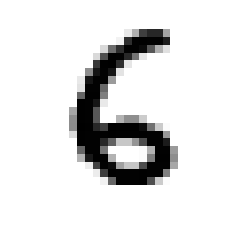

In [64]:
# Draw it
some_example = some_example.reshape(28, 28)

fig = plt.figure()
plt.imshow(some_example, cmap=plt.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [65]:
# Take a look at its class
mnist_y_train[idx]

6

<ul>
    <li>We don't really need scikit-learn pipelines this time.</li>
    <li>But we do need to reshape:
        <ul>
            <li>Our training data is in a 3D array of shape (60000, 28, 28).</li>
            <li>We change it to a 2D array of shape (60000, 28 * 28).
                <ul>
                    <li>This 'flattens' the images.</li>
                    <li>When working with images, it is often better not to do this. In a future lecture, we'll
                        build neural networks that do not require us to flatten.
                    </li>
                </ul>
            </li>
            <li>Similarlly, the test data.</li>
        </ul>
    </li>
</ul>

In [66]:
mnist_x_train = mnist_x_train.reshape((60000, 28 * 28))

mnist_x_test = mnist_x_test.reshape((10000, 28 * 28))

<ul>
    <li>We'll do a two-layer network:
        <ul>
            <li>One hidden layer with 512 neurons, using the ReLU activation function.</li>
            <li>The output layer will have 10 neurons, one per class, and 
                will use the softmax activation function.</li>
        </ul>
    </li>
    <li>Prior to those two layers of neurons, we'll have another layer, which will scale:
        <ul>
            <li>The values in the original datasset are integers in $[0, 255]$.</li>
            <li>The Rescaling layer changes them to floats in $[0, 1]$.</li>
        </ul>
        By doing this in a layer, we don't need a scikit-learn pipeline.
    </li>
</ul>

In [67]:
inputs = Input(shape=(28 * 28,))
x = Rescaling(scale=1./255)(inputs)
x = Dense(512, activation="relu")(x)
outputs = Dense(10, activation="softmax")(x)
mnist_model = Model(inputs, outputs)

mnist_model.compile(optimizer=SGD(learning_rate=0.01), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

<ul>
    <li>We'll use Keras functions for training and testing.</li>
</ul>

In [68]:
mnist_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 784)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_24 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


<ul>
    <li>Make sure you understand all the numbers above!
    </li>
</ul>

In [69]:
mnist_model.fit(mnist_x_train, mnist_y_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6157 - accuracy: 0.8495
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3234 - accuracy: 0.9104
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2745 - accuracy: 0.9229
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2438 - accuracy: 0.9328
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2207 - accuracy: 0.9388
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2018 - accuracy: 0.9442
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1860 - accuracy: 0.9483
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1725 - accuracy: 0.9521
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1608 - accuracy: 0.9558
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.150

In [70]:
test_loss, test_acc = mnist_model.evaluate(mnist_x_test, mnist_y_test)
test_acc

313/313 [==============================] - 1s 3ms/step - loss: 0.1487 - accuracy: 0.9569


0.9569000601768494

<ul>
    <li>Compare training accuracy and test accuracy.</li>
</ul>

<h1>Concluding Remarks</h1>
<ul>
    <li>A few decisions are constrained: number of inputs; number of output neurons; activation
        function of output neurons; and (to some extent) loss function.
    </li>
    <li>But there are numerous hyperparameters (and even more to come!)
        <ul>
            <li>Even making a good guess at them is more art than science, although this is changing.</li>
            <li>On the other hand, grid search or randomized search will make things even slower than they
                already are &mdash; and we still have to specify some sensible values for
                them to search through.
            </li>
        </ul>
    </li>
    <li>There is a considerable risk of overfitting.</li>
</ul>